In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#  read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build a vocabulary of character and mappings to/form integers
chars = sorted(list(set(''.join(words)))) # vocab
stoi = {s:i+1 for i, s in enumerate(chars)} # char to int
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()} # int to char 
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset

block_size = 5

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w +'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8* len(words))
n2 = int(0.9* len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [8]:
C = torch.randn(27,2)
print(C.shape)

torch.Size([27, 2])


In [9]:
# emb = C[[0,1,2]]
# print(emb)
# emb.shape

In [10]:
emb = C[X]
# print(emb)
emb.shape # (N, block_size, 2 = weight per neuron in the hidden layer) 

torch.Size([228146, 3, 2])

In [11]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [13]:
h

tensor([[-0.1815,  0.6526,  0.9534,  ..., -0.4461,  0.6660,  0.1194],
        [-0.1776,  0.8544,  0.9989,  ...,  0.2493, -0.6681,  0.4742],
        [ 0.8798, -0.9457, -0.9541,  ..., -0.9443,  0.9998, -0.3621],
        ...,
        [-0.9502,  0.8915, -0.0178,  ..., -0.1044, -0.8431, -0.9583],
        [ 0.8812, -0.8579, -0.9985,  ..., -0.9506,  0.9989, -0.9725],
        [-0.9952,  0.8749,  0.7829,  ..., -0.1835, -0.9987, -0.7909]])

In [14]:
h.shape[0] # (N, 100=neurons in the hidden layer)

228146

In [15]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [16]:
logits = h @ W2 + b2

In [17]:
logits.shape

torch.Size([228146, 27])

In [18]:
counts = logits.exp() # counts of each output character

In [19]:
# make it as probabilities of each output character
prob = counts / counts.sum(1, keepdims=True)  # sum along the 27 characters

In [20]:
prob.shape

torch.Size([228146, 27])

In [21]:
loss = -prob[torch.arange(h.shape[0]), Y].log().mean()
loss

tensor(15.9653)

In [22]:
# ------------ now made respectable :) ---------------

In [23]:
Xtr.shape, Ytr.shape # training dataset

(torch.Size([182625, 5]), torch.Size([182625]))

In [24]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((50, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [25]:
sum(p.nelement() for p in parameters)

15897

In [26]:
for p in parameters:
    p.requires_grad = True

In [27]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponents -3 = 0.001, 0 = 1
lrs = 10**lre # learning rates
print(lre[:10])
print(lrs[:10])

tensor([-3.0000, -2.9970, -2.9940, -2.9910, -2.9880, -2.9850, -2.9820, -2.9790,
        -2.9760, -2.9730])
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011])


In [28]:
lri = []
lossi = []
stepi = []

In [29]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,)) # 32 random indices

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10); one hot encoding; 32 samples 3 characters, 10 neurons; 
                    # Plucking out the embeddings for the 32 samples
                    # Plucking the firings of the 10 neurons for the 3 characters for the 32 samples
    h = torch.tanh(emb.view(-1, 50) @ W1 + b1) # (32, 200) ; 32 samples, 200 neurons
    logits = h @ W2 + b2 # (32, 27); 32 samples, 27 characters
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr  = 0.3 if i < 100000 else 0.01
    for p in parameters: 
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())


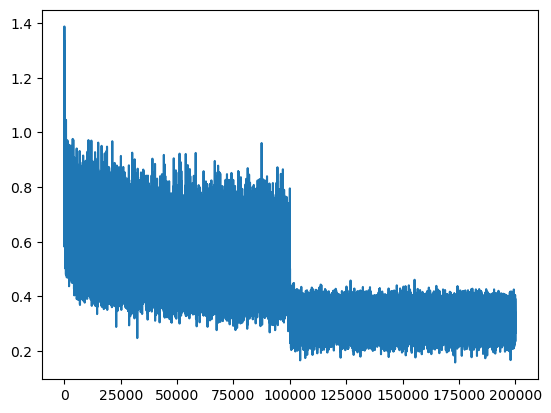

In [30]:
plt.plot(stepi, lossi)

In [31]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 50) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0852, grad_fn=<NllLossBackward0>)

In [32]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 50) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1476, grad_fn=<NllLossBackward0>)

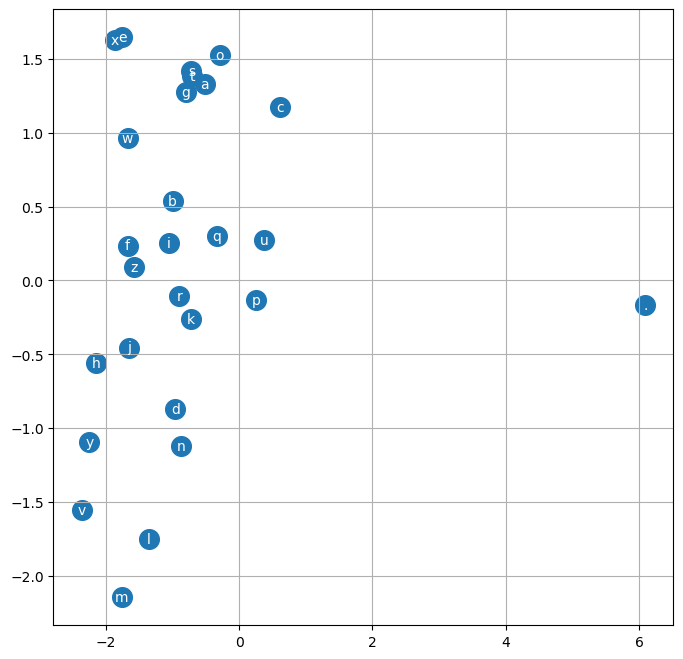

In [33]:
# WARNING: Will only work if the model only has 2 neurons in the hidden layer

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [34]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [35]:
# How to sample from the model

In [36]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 5, 10])

In [37]:
# sample form the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d) (1, 3, 10)
        h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmaliah.
jhleigh.
mrixhen.
cahnan.
saeja.
hutefamesarc.
kaquil.
ramari.
chaiir.
kaleigh.
hamon.
caderian.
suline.
liven.
corae.
madiarynn.
jacen.
dusti.
edde.
iia.


In [38]:
# ------- knowing the probability of a name from the model -------

In [60]:
# build the dataset

block_size = 5

X, Y = [], []
for w in ['kriz']:
    context = [0] * block_size
    for ch in w+ '.':
        ix = stoi[ch]
        # print(f'{context} -> {ix}')
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
# print(X.shape, Y.shape)

# forward pass
emb = C[X] # (32, 3, 10); one hot encoding; 32 samples 3 characters, 10 neurons; 
                # Plucking out the embeddings for the 32 samples
                # Plucking the firings of the 10 neurons for the 3 characters for the 32 samples
h = torch.tanh(emb.view(-1, 50) @ W1 + b1) # (32, 200) ; 32 samples, 200 neurons
logits = h @ W2 + b2 # (32, 27); 32 samples, 27 characters
counts = logits.exp() # counts of each output character
prob = counts / counts.sum(1, keepdims=True)  # sum along the 27 characters
loss = -prob[torch.arange(h.shape[0]), Y].log().mean()
print(Y)
print(prob.shape)
# print(prob[:,Y])
print(prob[0])

print(f'{loss=}')
# print(prob(torch.arange(Y.shape[0]), Y))
# print(f'{X} -> {prob}')
# logprob = torch.log(prob)
# log_likelihood = logprob.sum()



# print(f'{log_likelihood=}')
# nll = -log_likelihood
# print(f'{nll=}')
# print(f'{nll/h.shape[0]}')
# loss = F.cross_entropy(logits, Ytr[ix])


tensor([11, 18,  9, 26,  0])
torch.Size([5, 27])
tensor([1.0301e-06, 1.5997e-01, 3.7999e-02, 4.6366e-02, 5.6386e-02, 4.6907e-02,
        1.1743e-02, 2.1231e-02, 2.5615e-02, 1.8677e-02, 8.3422e-02, 7.4474e-02,
        4.4945e-02, 7.5451e-02, 2.7655e-02, 1.2373e-02, 1.7051e-02, 2.9392e-03,
        5.8139e-02, 6.0073e-02, 4.4512e-02, 2.7275e-03, 1.2554e-02, 1.2287e-02,
        4.5372e-03, 1.3998e-02, 2.7964e-02], grad_fn=<SelectBackward0>)
loss=tensor(2.6059, grad_fn=<NegBackward0>)


In [40]:
# ----- intial learning rate -----

In [41]:
# g = torch.Generator().manual_seed(2147483647) # for reproducibility
# C = torch.randn((27, 10), generator=g)
# W1 = torch.randn((50, 200), generator=g)
# b1 = torch.randn(200, generator=g)
# W2 = torch.randn((200, 27), generator=g)
# b2 = torch.randn(27, generator=g)
# parameters = [C, W1, b1, W2, b2]
# sum(p.nelement() for p in parameters)
# for p in parameters:
#     p.requires_grad = True

In [42]:
# for p in parameters:
#     p.requires_grad = True

In [43]:
# # lrs = torch.linspace(0.001, 1, 1000)

# lre = torch.linspace(-3, 0, 1000) # learning rate exponents -3 = 0.001, 0 = 1
# lrs = 10**lre # learning rates
# print(lre[:10])
# print(lrs[:10])

In [44]:
# lri = []
# lossi = []
# stepi = []

In [45]:
# for i in range(1000):
#     # minibatch construct
#     ix = torch.randint(0, Xtr.shape[0], (64,)) # 32 random indices

#     # forward pass
#     emb = C[Xtr[ix]] # (32, 3, 10); one hot encoding; 32 samples 3 characters, 10 neurons; 
#                     # Plucking out the embeddings for the 32 samples
#                     # Plucking the firings of the 10 neurons for the 3 characters for the 32 samples
#     h = torch.tanh(emb.view(-1, 50) @ W1 + b1) # (32, 200) ; 32 samples, 200 neurons
#     logits = h @ W2 + b2 # (32, 27); 32 samples, 27 characters
#     loss = F.cross_entropy(logits, Ytr[ix])
#     # print(loss.item())

#     # backward pass
#     for p in parameters:
#         p.grad = None
#     loss.backward()

#     # update
#     lr = lrs[i]
#     # lr  = 0.1 if i < 100000 else 0.01
#     for p in parameters: 
#         p.data += -lr * p.grad

#     # track stats
#     lri.append(lrs[i])
#     # stepi.append(i)
#     lossi.append(loss.item())

# # print(loss.item())


In [46]:
# plt.plot(lri, lossi)

In [47]:
# ------- find the possibility of a given name ----